In [ ]:
import matplotlib.pylab as plt
from agreement_functions import *

ModuleNotFoundError: No module named 'functions'

In [ ]:
wh = 1
sc = 10
st = 1
base_dir = "showers-data2/"

In [4]:
cmssw_hits_in = read_hits_files(f"{base_dir}Input_CMSSW/digis_IN_FPGA/digis_wh{wh}_sc{sc}_st{st}.txt", file_type="emu")
fpga_hits_in = pd.concat(
    [
        read_hits_files(f"{base_dir}FPGA_Outputs/HitLog/Hitlog_wh{wh}_sc{sc}_st{st}_SL0.txt", file_type="fpga"),
        read_hits_files(f"{base_dir}FPGA_Outputs/HitLog/Hitlog_wh{wh}_sc{sc}_st{st}_SL1.txt", file_type="fpga")
    ]
)
cmssw_showers = read_showers_files(f"{base_dir}Input_CMSSW/Shower_results_Emulator/showers_wh{wh}_sc{sc}_st{st}.txt", file_type="emu")
fpga_showers = pd.concat(
    [
        read_showers_files(f"{base_dir}FPGA_Outputs/ShowerOutput/output_wh{wh}_sc{sc}_st{st}_SL0.txt", file_type="fpga"),
        read_showers_files(f"{base_dir}FPGA_Outputs/ShowerOutput/output_wh{wh}_sc{sc}_st{st}_SL1.txt", file_type="fpga")
    ]
)

In [5]:
# use the cmssw_hits_info to set missing vars to others dataframes
fpga_hits_in["event"] = fpga_hits_in.apply(lambda row: cmssw_hits_in.loc[cmssw_hits_in["id"]==row["id"], "event"].values[0], axis=1)
fpga_hits_in["bxsend"] = fpga_hits_in.apply(lambda row: cmssw_hits_in.loc[cmssw_hits_in["id"]==row["id"], "bxsend"].values[0], axis=1)
fpga_showers["event"] = fpga_showers.apply(set_shower_event,args=(cmssw_hits_in,), axis=1)
fpga_showers["bxsend"] = fpga_showers.apply(set_shower_bxsend,args=(cmssw_hits_in,), axis=1)
cmssw_showers["bxsend"] = cmssw_showers.apply(set_shower_bxsend,args=(cmssw_hits_in,), axis=1)

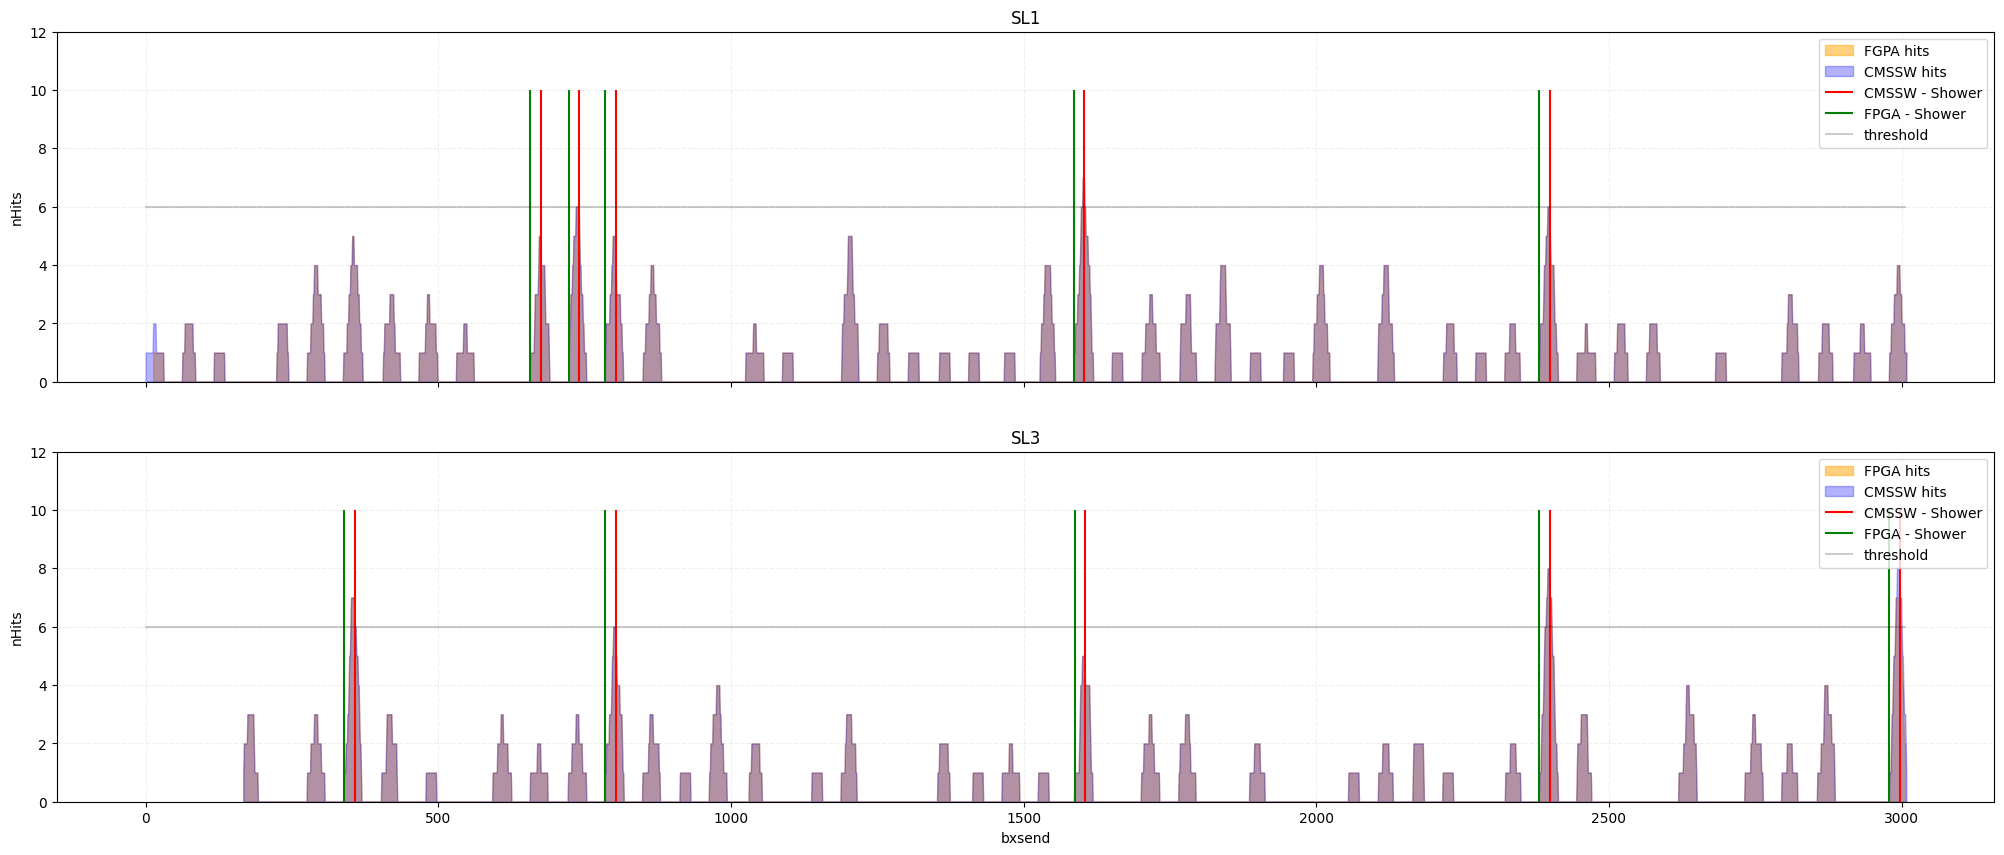

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(25, 10), sharex=True)
axs = axs.flatten()

cmssw_showers_kwargs={"color":"r", "label":"CMSSW - Shower"}
fpga_showers_kwargs={"color":"g", "label":"FPGA - Shower"}

nhits_cmsssw_sl1 = dump_hits_to_nhits(cmssw_hits_in.loc[cmssw_hits_in["sl"] == 1])
nhits_cmsssw_sl3 = dump_hits_to_nhits(cmssw_hits_in.loc[cmssw_hits_in["sl"] == 3])
nhits_fpga_sl1 = dump_hits_to_nhits(fpga_hits_in.loc[fpga_hits_in["sl"] == 1])
nhits_fpga_sl3 = dump_hits_to_nhits(fpga_hits_in.loc[fpga_hits_in["sl"] == 3])

cmssw_showers_bxs_sl1 = cmssw_showers.loc[cmssw_showers["sl"]==1]["bxsend"].values
fpga_showers_bxs_sl1 = fpga_showers.loc[fpga_showers["sl"]==1]["bxsend"].values
cmssw_showers_bxs_sl3 = cmssw_showers.loc[cmssw_showers["sl"]==3]["bxsend"].values
fpga_showers_bxs_sl3 = fpga_showers.loc[fpga_showers["sl"]==3]["bxsend"].values

axs[0].fill_between(nhits_fpga_sl1[:, 0], nhits_fpga_sl1[:, 1], alpha=0.5, color="orange", label="FGPA hits")
axs[0].fill_between(nhits_cmsssw_sl1[:, 0], nhits_cmsssw_sl1[:, 1], alpha=0.3, color="b", label="CMSSW hits")
axs[0].vlines(cmssw_showers_bxs_sl1, 0, 10, 'r', **cmssw_showers_kwargs)
axs[0].vlines(fpga_showers_bxs_sl1, 0, 10, 'g', **fpga_showers_kwargs)
axs[0].hlines(6, -1, nhits_cmsssw_sl1[-1][0], 'k', alpha=0.2, label="threshold")

axs[1].fill_between(nhits_fpga_sl3[:, 0], nhits_fpga_sl3[:, 1], alpha=0.5, color="orange", label="FPGA hits")
axs[1].fill_between(nhits_cmsssw_sl3[:, 0], nhits_cmsssw_sl3[:, 1], alpha=0.3, color="b", label="CMSSW hits")
axs[1].vlines(cmssw_showers_bxs_sl3, 0, 10, 'r', **cmssw_showers_kwargs)
axs[1].vlines(fpga_showers_bxs_sl3, 0, 10, 'g', **fpga_showers_kwargs)
axs[1].hlines(6, -1, nhits_cmsssw_sl3[-1][0], 'k', alpha=0.2, label="threshold")


axs[0].set_title("SL1")
axs[1].set_title("SL3")

axs[1].set_xlabel("bxsend")
axs[0].set_ylabel("nHits")
axs[1].set_ylabel("nHits")

for ax in axs:
    ax.set_ylim(0, 12)
    ax.grid(alpha=0.2, ls="--")
    ax.legend()

In [7]:
columns = ['sl', 'bx', 'tdc', 'l', 'w', 'id', 'wh', 'sc', 'st']
lost_hits = get_missing_hits(cmssw_hits_in, fpga_hits_in, columns)

diff_hits_tolerance=2

if lost_hits.size > diff_hits_tolerance:
    SL1_agreement = compute_agreement(fpga_showers.loc[fpga_showers["sl"]==1], cmssw_showers.loc[cmssw_showers["sl"]==1])
    SL3_agreement = compute_agreement(fpga_showers.loc[fpga_showers["sl"]==3], cmssw_showers.loc[cmssw_showers["sl"]==3])
    
    station_agreement = np.mean([SL1_agreement, SL3_agreement])
    err_station_agreement = np.std([SL1_agreement, SL3_agreement], ddof=1)
    
    print("SL1 match agreement: %.2f"%(SL1_agreement))
    print("SL3 match agreement: %.2f"%(SL3_agreement))
    print("Station match agreement : %.2f +- %.2f"%(station_agreement,err_station_agreement))
else:
    print("Several hits have been lost, agreement calculation not recomended.")

SL1 match agreement: 1.00
SL3 match agreement: 1.00
Station match agreement : 1.00 +- 0.00
